In [40]:
from collections import defaultdict
from functools import cache
from pathlib import Path
from glob import glob
import sys

parent = str(Path(sys.path[0]) / "..")
if parent not in sys.path:
    sys.path.append(parent)

from utils import hr_time_to_float, plot_linear_scaling_seaborn

import numpy as np
import pandas as pd
import seaborn as sns

def last_float(line: str) -> float:
    return float(line.split()[-1])


class Times:
    def __init__(self):
        self.times = defaultdict(list)
        self.metadata = {}

    def append(self, d):
        for k, v in d.items():
            self.times[k].append(v)

    def metadata_update(self, d):
        for k, v in d.items():
            if k in self.metadata:
                assert v == self.metadata[k]
            self.metadata[k] = v

    def get_max_times(self):
        return {k: max(v) for k, v in self.times.items()}


def read_file(filename):
    savetime = []
    readtime = []
    phase = "therm"
    fixed_a_swap_count = 0
    fixed_a_step_per_swap = 0
    fixed_a_time = np.nan
    with open(filename) as f:
        for line in f:
            if line.startswith("[SYSTEM][0][RepID: "):
                local_ranks = int(line.split()[-1].strip("]"))
            elif line.startswith("[SYSTEM][0][MPI_ID: "):
                global_ranks = int(line.split()[-1].strip("]"))
            elif line.startswith("[GEOMETRY_INIT][0]Global size is"):
                nt, nx, ny, nz = map(int, line.split()[-1].split("x"))
            elif line.startswith("[MAIN][0]0...20...40...60...80...Thermalization done"):
                assert phase == "therm"
                therm_time = hr_time_to_float(line)
                phase = "nr"
            elif line.startswith("[MAIN][0]Newton Raphson sequence #"):
                assert phase == "nr"
                nr_time = hr_time_to_float(line)
                phase = "rm"
            elif line.startswith("[MAIN][0]Robbins Monro sequence #"):
                assert phase == "rm"
                rm_time = hr_time_to_float(line)
                phase = "finalise_rm"
            elif line.startswith("[MAIN][0]Total simulation time ="):
                if phase == "finalise_rm":
                    phase = "fixed_a"
                elif phase == "fixed_a":
                    fixed_a_time = hr_time_to_float(line)
            elif line.startswith("[MAIN][0]Number of fixed a steps"):
                fixed_a_swap_count = int(line.split()[-1])
            elif line.startswith("[MAIN][0]Swap frequency for fixed a steps"):
                fixed_a_step_per_swap = int(line.split()[-1])
            elif line.startswith("[IO][0]Configuration"):
                split_line = line.split()
                if split_line[2] == "saved":
                    savetime.append(float(split_line[3].lstrip("[")))
                elif split_line[2] == "read":
                    readtime.append(float(split_line[3].lstrip("[")))

    fixed_a_count = fixed_a_swap_count * fixed_a_step_per_swap
    if fixed_a_count == 0:
        fixed_a_iteration_time = np.nan
    else:
        fixed_a_iteration_time = fixed_a_time / fixed_a_count
    return {
        "Number of CPUs per replica": local_ranks,
        "Number of replicas": global_ranks // local_ranks,
        "nt": nt,
        "nx": nx,
        "ny": ny,
        "nz": nz,
        "$N_t$": f"{nt}",
        "$V$": f"${nt}\\times{nx}^3$",
        "$L$": nx,
    }, {
        "Thermalisation time /s": therm_time,
        "Newton–Raphson time /s": nr_time,
        "Robbins–Monro time /s": rm_time,
        "Fixed-a iteration time /s": fixed_a_iteration_time,
        "Configuration save time /s": max(savetime),
        "Configuration read time /s": max(readtime),
    }


def read_dir(dirname):
    dir_times = Times()
    for filename in glob(f"{dirname}/*/Rep_*/out_0"):
        file_metadata, file_times = read_file(filename)
        dir_times.append(file_times)
        dir_times.metadata_update(file_metadata)

    return {
        **dir_times.get_max_times(),
        **dir_times.metadata,
    }

In [41]:
results_list = []

for top_dirname in glob("*_scaling"):
    if "CSD3" in top_dirname:
        system = "CSD3"
    elif "DIaL3" in top_dirname:
        system = "DIaL3"
    else:
        raise ValueError("Unrecognised system")

    for subdirname in glob(f"{top_dirname}/*"):
        result = read_dir(subdirname)
        result["System"] = system
        results_list.append(result)

results = pd.DataFrame(results_list)

In [42]:
results_melted = results.melt(
    id_vars=['Number of CPUs per replica', 'Number of replicas', 'nt', 'nx', 'ny', 'nz', '$N_t$', "$V$", '$L$', 'System'],
    value_vars=["Thermalisation time /s", "Newton–Raphson time /s", "Robbins–Monro time /s", "Fixed-a iteration time /s", "Configuration save time /s", "Configuration read time /s"],
    var_name="Metric",
    value_name="Time /s",
)

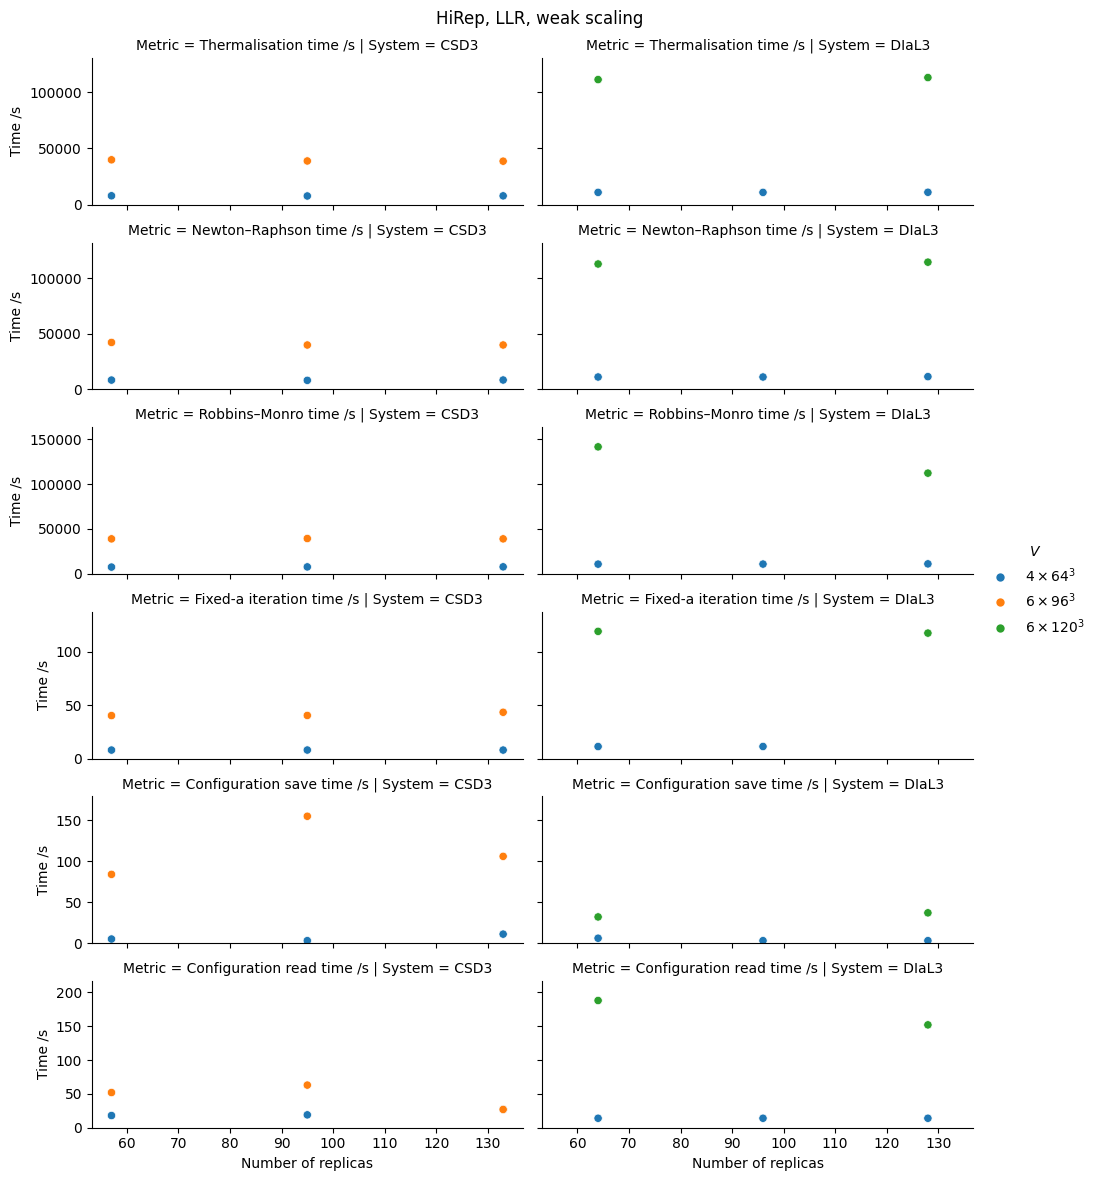

In [48]:
g = sns.relplot(
    results_melted,
    x="Number of replicas",
    y="Time /s",
    col="System",
    row="Metric",
    facet_kws={"sharey": "row"},
    hue="$V$",
    aspect=2.5,
    height=2,
)
for ax in g.axes.ravel():
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax * 1.05)

g.fig.suptitle("HiRep, LLR, weak scaling")
g.fig.subplots_adjust(top=0.94)

g.savefig("hirep-llr.pdf")

In [38]:
results[(results.nt == 6) & (results["Number of replicas"] < 70)]

,Thermalisation time /s,Newton–Raphson time /s,Robbins–Monro time /s,Fixed-a iteration time /s,Configuration save time /s,Configuration read time /s,Number of CPUs per replica,Number of replicas,nt,nx,ny,nz,$N_t$,$L$,System
8,39902.184846,42221.124074,39004.472150,40.236828,84.0,52.0,4,57,6,96,96,96,6,96,CSD3
9,111167.701499,112860.562684,141368.406811,119.135286,32.0,188.0,4,64,6,120,120,120,6,120,DIaL3


In [39]:
results

,Thermalisation time /s,Newton–Raphson time /s,Robbins–Monro time /s,Fixed-a iteration time /s,Configuration save time /s,Configuration read time /s,Number of CPUs per replica,Number of replicas,nt,nx,ny,nz,$N_t$,$L$,System
0,7771.841774,8089.174724,7824.395088,7.962323,3.0,19.0,4,95,4,64,64,64,4,64,CSD3
1,7950.699525,8337.543315,7617.054437,7.932965,5.0,18.0,4,57,4,64,64,64,4,64,CSD3
2,7886.296045,8398.159314,7882.017713,7.931472,11.0,27.0,4,133,4,64,64,64,4,64,CSD3
3,11071.631248,11432.382730,11182.644679,NaN,3.0,14.0,4,128,4,64,64,64,4,64,DIaL3
4,10968.156596,11098.504501,10971.412990,11.281253,3.0,14.0,4,96,4,64,64,64,4,64,DIaL3
5,10973.074491,11111.265541,10911.668350,11.231033,6.0,14.0,4,64,4,64,64,64,4,64,DIaL3
6,38876.878958,39914.972960,39398.977570,40.353886,155.0,63.0,4,95,6,96,96,96,6,96,CSD3
7,38698.293658,39933.787770,39015.738365,43.333765,106.0,27.0,4,133,6,96,96,96,6,96,CSD3
8,39902.184846,42221.124074,39004.472150,40.236828,84.0,52.0,4,57,6,96,96,96,6,96,CSD3
9,111167.701499,112860.562684,141368.406811,119.135286,32.0,188.0,4,64,6,120,120,120,6,120,DIaL3


## Without domain decomposition

In [44]:
results_list = []

for top_dirname in glob("*_no_domain_decomposition"):
    if "CSD3" in top_dirname:
        system = "CSD3"
    elif "DIaL3" in top_dirname:
        system = "DIaL3"
    else:
        raise ValueError("Unrecognised system")

    for subdirname in glob(f"{top_dirname}/*"):
        result = read_dir(subdirname)
        result["System"] = system
        results_list.append(result)

results_nodd = pd.DataFrame(results_list)

In [45]:
results_nodd_melted = results_nodd.melt(
    id_vars=['Number of CPUs per replica', 'Number of replicas', 'nt', 'nx', 'ny', 'nz', '$N_t$', "$V$", '$L$', 'System'],
    value_vars=["Thermalisation time /s", "Newton–Raphson time /s", "Robbins–Monro time /s", "Fixed-a iteration time /s", "Configuration save time /s", "Configuration read time /s"],
    var_name="Metric",
    value_name="Time /s",
)

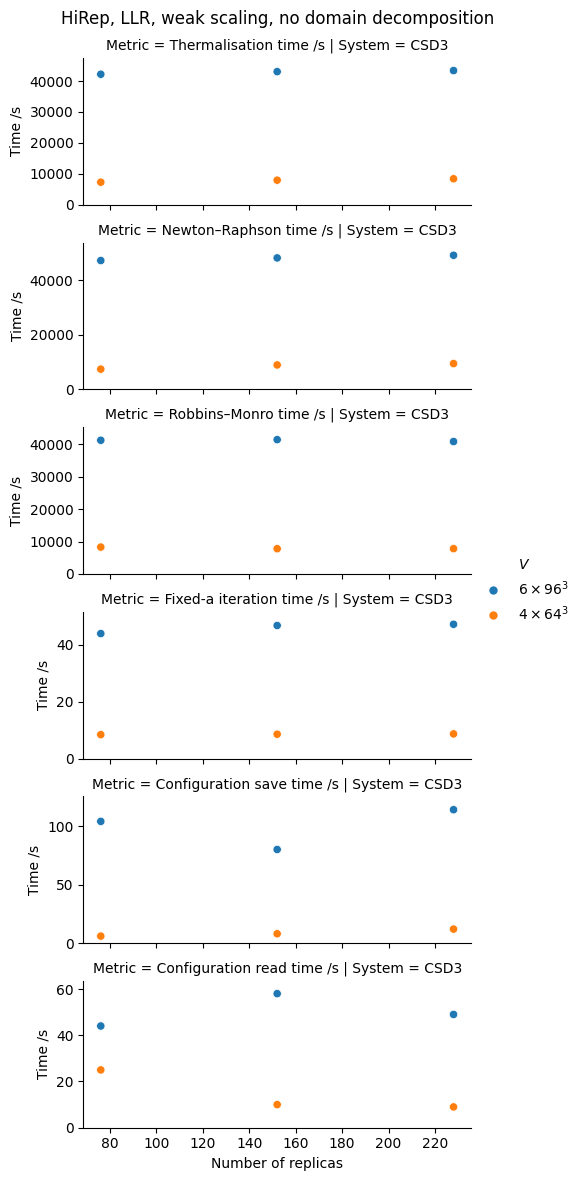

In [47]:
g = sns.relplot(
    results_nodd_melted,
    x="Number of replicas",
    y="Time /s",
    col="System",
    row="Metric",
    facet_kws={"sharey": "row"},
    hue="$V$",
    aspect=2.5,
    height=2,
)
for ax in g.axes.ravel():
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax * 1.05)

g.fig.suptitle("HiRep, LLR, weak scaling, no domain decomposition")
g.fig.subplots_adjust(top=0.94)

g.savefig("hirep-llr-nodd.pdf")

In [51]:
results_nodd

,Thermalisation time /s,Newton–Raphson time /s,Robbins–Monro time /s,Fixed-a iteration time /s,Configuration save time /s,Configuration read time /s,Number of CPUs per replica,Number of replicas,nt,nx,ny,nz,$N_t$,$V$,$L$,System
0,42188.263990,47255.455920,41289.319891,43.932927,104.0,44.0,1,76,6,96,96,96,6,$6\times96^3$,96,CSD3
1,7290.272103,7409.717110,8293.052029,8.395815,6.0,25.0,1,76,4,64,64,64,4,$4\times64^3$,64,CSD3
2,7939.224458,8943.427508,7791.622300,8.549512,8.0,10.0,1,152,4,64,64,64,4,$4\times64^3$,64,CSD3
3,43031.605948,48217.537265,41483.646056,46.770403,80.0,58.0,1,152,6,96,96,96,6,$6\times96^3$,96,CSD3
4,8399.984390,9451.225389,7808.115405,8.664854,12.0,9.0,1,228,4,64,64,64,4,$4\times64^3$,64,CSD3
5,43378.482375,49188.832542,40896.344347,47.193582,114.0,49.0,1,228,6,96,96,96,6,$6\times96^3$,96,CSD3
